In [1]:
%cd '/app'

/app


In [2]:
%load_ext autoreload
%autoreload 2

### Loading border basis dataset 

In [3]:
import os

# CUDE_VISIBLE_DEVICES=6
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

from pathlib import Path
from src.loader.data import load_data
from src.loader.data_format.processors.base import ProcessorChain

In [4]:
from src.loader.checkpoint import load_pretrained_bag

save_path = 'results/train/expansion/expansion/custom_bart/base_k_lt=5_m=100000'
bag = load_pretrained_bag(save_path, from_checkpoint=True)

model = bag['model']
tokenizer = bag['tokenizer']
config = bag['config']

model.eval();

/app/src/loader/checkpoint.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(os.path.join(checkpoint_path, f'pytorch_model.bin'))


In [5]:
# load config

data_path  = f"data/border_basis/GF31_n=3_deg=4_terms=10_bounds=4_4_4_total=4"


import yaml
with open(f'{data_path}/config.yaml', 'r') as f:
    exp_config = yaml.safe_load(f)

data_path  = f"data/expansion/GF31_n=3_deg=4_terms=10_bounds=4_4_4_total=4"

from src.loader.data_format.processors.expansion import ExtractKLeadingTermsProcessor
from src.loader.data_format.processors.subprocessors import MonomialProcessorPlus


data_collator_name = 'monomial'

_processors = []
_processors.append(ExtractKLeadingTermsProcessor(config.num_leading_terms))

subprocessors = {}
subprocessors['monomial_ids'] = MonomialProcessorPlus(
            num_variables=config.num_variables,
            max_degree=config.max_degree,
            max_coef=int(config.field[2:])  # 'GF7' -> 7
        )

processor = ProcessorChain(_processors) 

# load test dataset
test_data_path = Path(data_path) / 'test'
test_dataset, data_collator = load_data(
    data_path=test_data_path,
    processor=processor,
    subprocessors=subprocessors,
    splits=[{"name": "test", "batch_size": 32, "shuffle": False}],
    tokenizer=tokenizer,
    return_dataloader=False,  # return dataloader if True
    data_collator_name=data_collator_name
)

test_dataset[0]

{'input': 'C1 E0 E1 E7 [SEP] C1 E1 E4 E3 [SEP] C1 E2 E3 E3 [SEP] C1 E3 E2 E3 [SEP] C1 E4 E1 E3 [SEP] C1 E5 E0 E3 [SEP] C1 E1 E5 E2 [SEP] C1 E2 E4 E2 [SEP] C1 E3 E3 E2 [SEP] C1 E4 E2 E2 [SEP] C1 E5 E1 E2 [SEP] C1 E6 E0 E2 [SEP] C1 E1 E6 E1 [SEP] C1 E2 E5 E1 [SEP] C1 E3 E4 E1 [SEP] C1 E4 E3 E1 [SEP] C1 E5 E2 E1 [SEP] C1 E6 E1 E1 [SEP] C1 E7 E0 E1 [SEP] C1 E2 E6 E0 [SEP] C1 E3 E5 E0 [SEP] C1 E4 E4 E0 [SEP] C1 E5 E3 E0 [SEP] C1 E6 E2 E0 [SEP] C1 E7 E1 E0 [SEP] C1 E8 E0 E0 [SEP] C1 E2 E0 E7 [SEP] C1 E1 E2 E6 [SEP] C1 E2 E1 E6 [SEP] C1 E3 E0 E6 [SEP] C1 E1 E3 E5 [SEP] C1 E2 E2 E5 [SEP] C1 E3 E1 E5 [SEP] C1 E4 E0 E5  [BIGSEP]  C1 E4 E1 E0 + C19 E3 E1 E1 + C27 E4 E0 E0 + C13 E3 E1 E0 + C21 E3 E0 E1  [SEP]  C1 E4 E1 E1 + C19 E3 E1 E2 + C27 E4 E0 E1 + C13 E3 E1 E1 + C21 E3 E0 E2  [SEP]  C1 E4 E2 E0 + C19 E3 E2 E1 + C27 E4 E1 E0 + C13 E3 E2 E0 + C21 E3 E1 E1  [SEP]  C1 E5 E1 E0 + C19 E4 E1 E1 + C27 E5 E0 E0 + C13 E4 E1 E0 + C21 E4 E0 E1  [SEP]  C1 E1 E2 E4 + C25 E0 E3 E4 + C14 E2 E0 E5 + C9 E1 E1

In [11]:
from torch.utils.data import DataLoader
from src.misc.utils import to_cuda
data_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=data_collator)

batch = next(iter(data_loader))
batch = to_cuda(batch)

In [12]:
import torch
with torch.no_grad():
    outputs = model(**batch)
    preds = outputs['logits'].argmax(dim=-1)
    labels = batch['labels']
    # acc = (preds[labels != -100] == labels[labels != -100]).float().mean()
    acc = (preds[labels != -100] == labels[labels != -100]).float().mean().item()
    loss = outputs['loss'].item()

print(f'acc: {acc:.4f}, loss: {loss:.4f}')


acc: 0.9823, loss: 0.0771


In [8]:
import torch
with torch.no_grad():
    ignore_index = -100
    outputs = model(**batch)
    logits = outputs['logits']
    labels = batch['labels']

    valid_mask = labels != ignore_index
    valid_labels = labels[valid_mask]
    valid_logits = logits[valid_mask]

    predictions = torch.argmax(valid_logits, dim=-1)
    
    # acc = (preds[labels != -100] == labels[labels != -100]).float().mean()
    error = (predictions != valid_labels).float().mean().item()
    loss = outputs['loss'].item()

print(f'error: {error:.4f}, loss: {loss:.4f}')


error: 0.0177, loss: 0.0771


In [9]:
from src.loader.data_format.processors.subprocessors import MonomialProcessorPlus

max_length = batch['labels'].shape[-1] + 1
mpp = MonomialProcessorPlus(num_variables=config.num_variables, max_degree=config.max_degree, max_coef=int(config.field[2:]))
generated = model.generate(batch['input_ids'], batch['attention_mask'], 
                           monomial_processor=mpp, tokenizer=tokenizer, 
                           max_length=max_length)

In [10]:
predictions  = mpp.batch_decode(generated, skip_special_tokens=True)

labels = batch['labels']
labels[labels == -100] = tokenizer.pad_token_id
labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

In [30]:
idx = 11
preds = predictions[idx].split('[SEP]')
pred_directions, pred_leading_terms = preds[::2], preds[1::2]

gts = labels[idx].split('[SEP]')
gt_directions, gt_leading_terms = gts[::2], gts[1::2]


print(f' # of predicted expansions: {len(pred_directions)}')
print(f' # of ground truth expansions: {len(gt_directions)}')

print('-'*100)
print(f'{"Prediction":<25} | {"Ground Truth":<25} | {"Correct":<5}')
print('-'*100)
print(f'{"Direction":<11} | {"Leading Trm":<10} | {"Direction":<11} | {"Leading Trm":<10} | {"Direc.":<5} | {"LT":<5} | {"Both":<5}')
print('-'*100)
for pred_direction, pred_leading_term, gt_direction, gt_leading_term in zip(pred_directions, pred_leading_terms, gt_directions, gt_leading_terms):
    
    direction_correct = pred_direction   == gt_direction
    lt_correct = pred_leading_term == gt_leading_term
    both_correct = direction_correct and lt_correct
    
    print(f'{pred_direction} | {pred_leading_term} | {gt_direction} | {gt_leading_term} | {str(direction_correct):<6} | {str(lt_correct):<6} | {str(both_correct):<6}')
    
    

 # of predicted expansions: 50
 # of ground truth expansions: 28
----------------------------------------------------------------------------------------------------
Prediction                | Ground Truth              | Correct
----------------------------------------------------------------------------------------------------
Direction   | Leading Trm | Direction   | Leading Trm | Direc. | LT    | Both 
----------------------------------------------------------------------------------------------------
C1 E1 E0 E0  |  C1 E4 E1 E0  | C1 E1 E0 E0  |  C1 E4 E1 E0  | True   | True   | True  
 C1 E0 E1 E0  |  C1 E4 E1 E0  |  C1 E0 E1 E0  |  C1 E4 E1 E0  | True   | True   | True  
 C1 E0 E0 E1  |  C1 E4 E1 E0  |  C1 E0 E0 E1  |  C1 E4 E1 E0  | True   | True   | True  
 C1 E1 E0 E0  |  C1 E5 E0 E0  |  C1 E1 E0 E0  |  C1 E5 E0 E0  | True   | True   | True  
 C1 E0 E1 E0  |  C1 E5 E0 E0  |  C1 E0 E1 E0  |  C1 E5 E0 E0  | True   | True   | True  
 C1 E0 E0 E1  |  C1 E5 E0 E0  |  C1 E0 E0 E1  

In [142]:
# predictions  = mpp.batch_decode(generated, skip_special_tokens=True)
labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

OverflowError: out of range integral type conversion attempted

In [135]:
for l in batch['labels']:
    print(l.shape)

torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])
torch.Size([490])


In [19]:
outputs = model.model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], decoder_input_ids=batch['decoder_input_ids'], decoder_attention_mask=batch['decoder_attention_mask'])

In [ ]:
outputs = model(**batch)
preds = outputs['logits'].argmax(dim=-1)

outputs['loss']

tensor(0.1298, device='cuda:0', grad_fn=<NllLossBackward0>)

In [11]:
batch['labels']

tensor([[   5,   36,   36,  ..., -100, -100, -100],
        [  63, -100, -100,  ..., -100, -100, -100],
        [   5,   37,   36,  ..., -100, -100, -100],
        ...,
        [   5,   37,   36,  ..., -100, -100, -100],
        [   5,   37,   36,  ..., -100, -100, -100],
        [   5,   36,   36,  ..., -100, -100, -100]], device='cuda:0')

In [12]:
valid = batch['labels'] != 61
(preds[valid] == batch['labels'][valid]).float().mean()

tensor(0.3199, device='cuda:0')

In [13]:
id = 10
decoded_preds = tokenizer.decode(preds[id], skip_special_tokens=True).split(' [SEP] ')
decoded_labels = tokenizer.decode(batch['labels'][id], skip_special_tokens=True).split(' [SEP] ')
[[a, b, a==b] for a, b in zip(decoded_preds, decoded_labels)]

OverflowError: out of range integral type conversion attempted

In [68]:
decoded_labels = tokenizer.decode(batch['labels'][2], skip_special_tokens=True).split(' [SEP] ')

In [69]:
[[a, b, a==b] for a, b in zip(decoded_preds, decoded_labels)]

[['C1 E0 E0 E1 [SEP]', 'C1 E1 E0 E0', False]]

In [231]:
from sage.all import *
ring = PolynomialRing(GF(31), 'x', 3, order='degrevlex')

In [249]:
decoded_texts[0]
sequence_to_poly(decoded_texts[0], ring)

TypeError: unable to convert '' to an integer

In [23]:
from src.dataset.processors.utils import sequence_to_poly
decoded_texts = tokenizer.batch_decode(preds[:, :-1], skip_special_tokens=True)
# decoded_texts = [sequence_to_poly(text, ring) for text in decoded_texts]
# decoded_texts = [dt.split()[:-1] if dt else dt for dt in decoded_texts]
decoded_texts[:4]

['C1 E0 E1 E0 [SEP] C1 E3 E4 E0 [SEP]',
 'C1 E0 E0 E1 [SEP]',
 'C1 E0 E1 E0 [SEP] C1 E0 E5 E1 [SEP] C1 E0 E1 E0 [SEP] C1 E1 E4 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E1 E4 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E0 E4 E2 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E3 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E3 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E2 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E2 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E2 E0 [SEP] C1 E1 E0 E0 [SEP] C1 E1 E3 E1 [SEP] C1 E0 E1 E0 [SEP] C1 E1 E3 E1 [SEP] C1 E0 E0 E1 [SEP] C1 E0 E3 E3 [SEP] C1 E0 E1 E0 [SEP] C1 E0 E3 E3',
 'C1 E1 E0 E0 [SEP] C1 E0 E2 E1 [SEP] C1 E1 E1 E0 [SEP] C1 E1 E6 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E0 E6 E0 [SEP] C1 E1 E0 E0 [SEP] C1 E4 E1 E1 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E1 E1 [SEP] C1 E0 E0 E1 [SEP] C1 E2 E3 E1 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E1 E2 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E1 E2 [SEP] C1 E0 E0 E1 [SEP] C1 E1 E3 E2 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E0 E3 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E0 E3 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E0 E3 [SEP] C1 E1 E0 E0 [SEP] C1 E2 E1 E3 [SEP] C1

In [28]:
labels = batch['labels']
labels[labels == -100] = tokenizer.pad_token_id
tokenizer.batch_decode(labels, skip_special_tokens=True)[:4]

['C1 E0 E0 E1 [SEP] C1 E1 E3 E1',
 '',
 'C1 E1 E0 E0 [SEP] C1 E1 E4 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E1 E4 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E1 E4 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E0 E4 E2 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E3 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E3 E0 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E2 E0 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E2 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E2 E0 [SEP] C1 E1 E0 E0 [SEP] C1 E1 E3 E1 [SEP] C1 E0 E1 E0 [SEP] C1 E1 E3 E1 [SEP] C1 E1 E0 E0 [SEP] C1 E0 E3 E3 [SEP] C1 E0 E0 E1 [SEP] C1 E0 E3 E3',
 'C1 E0 E0 E1 [SEP] C1 E2 E2 E2 [SEP] C1 E0 E0 E1 [SEP] C1 E1 E5 E0 [SEP] C1 E0 E0 E1 [SEP] C1 E1 E4 E1 [SEP] C1 E0 E0 E1 [SEP] C1 E5 E0 E1 [SEP] C1 E0 E1 E0 [SEP] C1 E2 E3 E1 [SEP] C1 E0 E0 E1 [SEP] C1 E4 E0 E2 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E1 E2 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E1 E2 [SEP] C1 E0 E1 E0 [SEP] C1 E1 E3 E2 [SEP] C1 E1 E0 E0 [SEP] C1 E3 E0 E3 [SEP] C1 E0 E1 E0 [SEP] C1 E3 E0 E3 [SEP] C1 E0 E0 E1 [SEP] C1 E3 E0 E3 [SEP] C1 E1 E0 E0 [SEP] C1 E2 E1 E3 [SEP] C1 E0 E1 E0 [SEP] C1 E2 E

In [275]:
tokenizer.decode(61)

'[PAD]'

In [267]:
batch['labels'] != tokenizer.pad_token_id

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0')

In [261]:
batch['labels']

tensor([[   5,   36,   36,  ...,   61,   61,   61],
        [  63,   61,   61,  ...,   61,   61,   61],
        [   5,   37,   36,  ...,   61,   61,   61],
        ...,
        [   5,   37,   36,  ...,   61,   61,   61],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]], device='cuda:0')

In [217]:
outputs

Seq2SeqLMOutput(loss=tensor(4.4995, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[-10.4059, -11.4984, -11.2304,  ...,   2.4077, -11.6887, -10.7370],
         [-24.4693, -24.6680, -24.6922,  ...,  -5.3014, -24.6362, -24.7874],
         [-23.0536, -23.1035, -23.4083,  ...,  -5.1396, -23.3535, -23.2488],
         ...,
         [-14.9247, -15.0943, -14.7434,  ...,  -1.2014, -14.9254, -14.8689],
         [-13.3075, -13.2106, -13.1984,  ...,  -0.9993, -13.3745, -13.1659],
         [-19.1048, -19.0126, -19.1906,  ...,  -9.4646, -19.0795, -18.9107]],

        [[-10.8350, -11.7923, -11.5299,  ...,   2.7475, -12.0603, -11.1324],
         [-23.8303, -24.0153, -24.0074,  ...,  -4.8655, -23.9860, -24.0805],
         [-22.7361, -22.7236, -23.0216,  ...,  -5.2049, -23.1075, -22.9658],
         ...,
         [-11.5923, -11.5744, -12.0024,  ...,  -3.6673, -12.0274, -11.6766],
         [-17.0731, -16.8038, -17.0046,  ...,  -3.3900, -17.1154, -16.9577],
         [-10.8845, -10.5951, -10.

In [18]:
from src.loader.data_format.processors.subprocessors import MonomialProcessorPlus

mpp = MonomialProcessorPlus(num_variables=3, max_degree=20, max_coef=31)

generated = model.generate(batch['input_ids'], batch['attention_mask'], monomial_processor=mpp, tokenizer=tokenizer, max_length=100)

In [19]:

mpp.decode(generated[0], skip_special_tokens=False)

'C1 E0 E0 E0 [BOS] C1 E0 E0 E0 [EOS] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 E0 [SEP] C1 E0 E0 

In [33]:
generated[0]

[autoreload of src.loader.models.custom_bart failed: Traceback (most recent call last):
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/sage/local/var/lib/sage/venv-python3.10/lib/python3.10/

tensor([[0, 0, 0, 0, 2],
        [0, 0, 0, 0, 3],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],


In [34]:
monomials = ['[PAD] E1 E0 E0 [SEP]', '[PAD] [PAD] [PAD] [PAD] [PAD]', '[PAD] E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>', 'C1 E1 E1 E0 </s>', '[PAD] [PAD] [PAD] [PAD] </s>', '[PAD] E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>', 'C1 E1 E1 E0 </s>', '[PAD] [PAD] [PAD] [PAD] </s>', '[PAD] E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>', 'C1 E1 E1 E0 </s>', '[PAD] [PAD] [PAD] [PAD] </s>', '[PAD] E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>', 'C1 E1 E1 E0 </s>', '[PAD] [PAD] [PAD] [PAD] </s>', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>', 'C1 E1 E1 E0 </s>', 'C1 E1 E0 E0 </s>', 'C1 E1 E0 E0 [SEP]', 'C1 E0 E0 E1 [SEP]', 'C1 E0 E0 E1 </s>']
mpp.is_valid_monomial(monomials[:4])

[False, False, False, True]

In [163]:
mpp.generation_helper(monomials[:4])

[[0, 0, 0, 0, 3], [0, 0, 0, 0, 3], [0, 0, 0, 0, 3], [(0, 0, 0, 1, 0)]]

In [16]:
from src.evaluation.generation import generation_accuracy



  0%|          | 0/131 [00:00<?, ?it/s]


UnboundLocalError: local variable 'preds' referenced before assignment

In [ ]:
print(train_dataset[id]['input'].split(' [BIGSEP] ')[2])
print(test_dataset[id]['input'].split(' [BIGSEP] ')[2])

In [57]:
id = 230

trainset_V = [train_sample['input'].split(' [BIGSEP] ') for train_sample in train_dataset]
testset_V = [test_sample['input'].split(' [BIGSEP] ') for test_sample in test_dataset]

In [58]:
for test_V in enumerate(testset_V):
    print(test_V in trainset_V)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [15]:
Ls_input = []
Ls_target = []
for sample in test_dataset:
    length_input = len(sample['input'].split())
    length_target = len(sample['target'].split())
    Ls_input.append(length_input)
    Ls_target.append(length_target)
    # print(length)
    # print(len(sample['target'].split()))


In [21]:
import numpy as np
Ls_input = np.array(Ls_input)
Ls_target = np.array(Ls_target)

print(f'input: {np.max(Ls_input)}, {np.mean(Ls_input):.1f}, {np.std(Ls_input):.1f}')
print(f'target: {np.max(Ls_target)}, {np.mean(Ls_target):.1f}, {np.std(Ls_target):.1f}')

input: 126004, 9539.8, 10897.5
target: 37654, 3497.9, 4147.0


In [22]:
input_text

'C28 E1 E2 E1 + C2 E0 E3 E1 + C30 E1 E2 E0 + C12 E0 E3 E0 + C1 E1 E0 E2 + C5 E2 E0 E0 + C30 E1 E1 E0 + C25 E0 E2 E0 + C21 E1 E0 E1 + C10 E0 E1 E1 + C15 E0 E0 E2 + C4 E0 E1 E0 + C14 E0 E0 E1 [SEP] C10 E2 E3 E0 + C26 E3 E1 E1 + C25 E2 E0 E3 + C19 E1 E3 E0 + C7 E0 E4 E0 + C6 E2 E1 E1 + C15 E1 E2 E1 + C5 E2 E0 E2 + C15 E1 E1 E2 + C11 E1 E0 E3 + C2 E0 E1 E3 + C17 E3 E0 E0 + C2 E2 E1 E0 + C24 E1 E2 E0 + C15 E0 E3 E0 + C20 E2 E0 E1 + C8 E1 E1 E1 + C1 E0 E2 E1 + C7 E1 E0 E2 + C11 E0 E1 E2 + C23 E0 E0 E3 + C24 E2 E0 E0 + C17 E1 E1 E0 + C16 E0 E2 E0 + C27 E1 E0 E1 + C19 E0 E1 E1 + C20 E0 E0 E2 + C16 E1 E0 E0 + C24 E0 E1 E0 + C18 E0 E0 E1 + C11 E0 E0 E0 [SEP] C26 E1 E3 E1 + C7 E1 E3 E0 + C30 E0 E4 E0 + C22 E2 E1 E1 + C23 E1 E2 E1 + C5 E0 E3 E1 + C14 E2 E0 E2 + C27 E1 E1 E2 + C23 E0 E2 E2 + C24 E1 E0 E3 + C10 E0 E1 E3 + C23 E0 E0 E4 + C30 E2 E1 E0 + C10 E1 E2 E0 + C26 E0 E3 E0 + C20 E2 E0 E1 + C7 E1 E1 E1 + C18 E0 E2 E1 + C2 E1 E0 E2 + C26 E0 E0 E3 + C3 E2 E0 E0 + C1 E1 E1 E0 + C22 E0 E2 E0 + C5 E

In [354]:
from src.loader.data_format.processors.subprocessors import MonomialProcessorPlus

mpp = MonomialProcessorPlus(num_variables=config['ring']['num_variables'], max_degree=config['polynomial']['max_degree'], max_coef=100)


input_texts = [sample['input'] for sample in test_dataset]
processed_input_text = mpp(input_texts)

TypeError: 'Namespace' object is not subscriptable

In [39]:
input_text[-50:]

'E0 E0 + C24 E0 E1 E0 + C28 E0 E0 E1 + C14 E0 E0 E0'

In [52]:
len(processed_input_text)
sum([len(tt) for tt in processed_input_text])

888

In [53]:
input_text.count('+')

843

In [57]:
(Ls_input[0] - input_text.count('+')) // 3

532

In [64]:
counter = 0
for test in input_text.split(' [BIGSEP]'):
    for test2 in test.split(' [SEP] '):
        counter += len(test2.split(' + '))
counter

888

### Retrieve SageMath objects

In [18]:
from sage.all import *
from src.dataset.processors.utils import sequence_to_poly, poly_to_sequence, get_field

field_name = f"{config['field']['type']}{config['field']['param']}"
field = get_field(field_name)
# ring = PolynomialRing(field, ['x', 'y', 'z'], order='degrevlex')
ring = PolynomialRing(field, 'x', config['ring']['num_variables'], order='degrevlex')

F = [sequence_to_poly(f_text, ring) for f_text in input_text.split(' [SEP] ')]
BB = [sequence_to_poly(g_text, ring) for g_text in target_text.split(' [SEP] ')]

In [19]:
ideal(BB).variety()

[{x2: 29, x1: 15, x0: 8}, {x2: 26, x1: 10, x0: 28}, {x2: 14, x1: 22, x0: 30}]

In [20]:
ideal(BB) == ideal(F)

True

### Run border basis calculator

In [21]:
%%time 
from src.border_basis_lib.improved_border_basis import ImprovedBorderBasisCalculator

calculator = ImprovedBorderBasisCalculator(ring, corollary_23=True, N=100, save_universes=True, verbose=False)

use_fast_elimination = True  # use gaussian_elimination_fast
lstabilization_only = False  # only compute L-stable span

G, O, _ = calculator.compute_border_basis_optimized(F,
                                            use_fast_elimination=use_fast_elimination,
                                            lstabilization_only=lstabilization_only)

calculator.datasets[0][0]

CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 120 ms


[[x0^2*x2^2,
  x1*x2^4,
  x0^3*x1*x2,
  x0*x1^2*x2^3,
  x1^4*x2^2,
  x0*x1^3*x2^2,
  x1^5*x2,
  x0*x1^4*x2,
  x0^2*x1^3*x2,
  x1^6,
  x0^3*x1^3],
 [x1^6 - 10*x0^2*x1^3*x2 - 9*x0*x1^4*x2 + 8*x1^5*x2 + 15*x0*x1^3*x2^2 + 10*x1^4*x2^2 + x0*x1^4 + 14*x1^5 + 4*x0*x1^3*x2 + 10*x1^4*x2 + 12*x0*x1^2*x2^2 - 5*x1^3*x2^2 - 9*x0*x1*x2^3 + 14*x1^2*x2^3 + 2*x1*x2^4 - 7*x0*x1^3 - 6*x1^4 + 11*x0^2*x1*x2 - 10*x0*x1^2*x2 - 5*x1^3*x2 - 6*x0*x1*x2^2 + 4*x1^2*x2^2 - 8*x1*x2^3 - 15*x0^2*x1 + 13*x0*x1^2 + 14*x1^3 - 15*x0^2*x2 - 9*x0*x1*x2 - 10*x1^2*x2 + 9*x0*x2^2 - 10*x1*x2^2 - 6*x2^3 + 6*x0*x1 - 13*x1^2 - 15*x0*x2 + 12*x1*x2 - 11*x0 - 3*x1 + 7*x2 + 13,
  x0^3*x1^2 + 7*x0*x1^4 - 2*x0*x1^3*x2 + 14*x1^2*x2^3 + 15*x0^3*x1 - 11*x0*x1^3 - 4*x1^4 - 15*x0^3*x2 - 12*x0*x1^2*x2 + 8*x1^3*x2 + 6*x1^2*x2^2 - 15*x0^3 + 14*x0^2*x1 + 6*x0*x1^2 - 5*x1^3 - 2*x0*x1*x2 - 14*x1^2*x2 - 11*x1*x2^2 + 3*x0^2 + 13*x0*x1 - x1^2 - 7*x1*x2 + 7*x2^2 + 5*x0 - x1 + 7*x2 + 7,
  x0^2*x1^3*x2 - 3*x0*x1^4*x2 + 13*x1^5*x2 + 5*x0*x1^3*x2^2 - 11*

### Get expantion dataset 

In [22]:
'''
    calculator.datasets[0][0] gives
    (L,  # Geneators of the order ideal O(L)
     V,  # Target set of polynomials to span,
     S,  # # List of polynomials that were successfully extended
     )
     
     From this, we construct 
     input: 
     (F, L, V)
     output: 
     (S)  
     
     Note: 
     It would be better to put something like [SUPER_SEP] instead of [SEP] between F, L, V. 
'''


## Get one sample
L, V, S = calculator.datasets[0][0]
inputs = F + L + V
target = S

inputs_text = [poly_to_sequence(f) for f in inputs]
inputs_text = ' [SEP] '.join(inputs_text)
target_text = [poly_to_sequence(f) for f in target]
target_text = ' [SEP] '.join(target_text)

sample_text = ' # '.join([inputs_text, target_text])

sample_text

'C16 E0 E6 E0 + C26 E2 E3 E1 + C11 E1 E4 E1 + C4 E0 E5 E1 + C23 E1 E3 E2 + C5 E0 E4 E2 + C16 E1 E4 E0 + C7 E0 E5 E0 + C2 E1 E3 E1 + C5 E0 E4 E1 + C6 E1 E2 E2 + C13 E0 E3 E2 + C11 E1 E1 E3 + C7 E0 E2 E3 + C1 E0 E1 E4 + C12 E1 E3 E0 + C28 E0 E4 E0 + C21 E2 E1 E1 + C26 E1 E2 E1 + C13 E0 E3 E1 + C28 E1 E1 E2 + C2 E0 E2 E2 + C27 E0 E1 E3 + C8 E2 E1 E0 + C22 E1 E2 E0 + C7 E0 E3 E0 + C8 E2 E0 E1 + C11 E1 E1 E1 + C26 E0 E2 E1 + C20 E1 E0 E2 + C26 E0 E1 E2 + C28 E0 E0 E3 + C3 E1 E1 E0 + C9 E0 E2 E0 + C8 E1 E0 E1 + C6 E0 E1 E1 + C10 E1 E0 E0 + C14 E0 E1 E0 + C19 E0 E0 E1 + C22 E0 E0 E0 [SEP] C20 E3 E2 E0 + C16 E1 E4 E0 + C22 E1 E3 E1 + C1 E0 E2 E3 + C21 E3 E1 E0 + C28 E1 E3 E0 + C13 E0 E4 E0 + C10 E3 E0 E1 + C8 E1 E2 E1 + C5 E0 E3 E1 + C27 E0 E2 E2 + C10 E3 E0 E0 + C1 E2 E1 E0 + C27 E1 E2 E0 + C24 E0 E3 E0 + C22 E1 E1 E1 + C30 E0 E2 E1 + C28 E0 E1 E2 + C29 E2 E0 E0 + C12 E1 E1 E0 + C11 E0 E2 E0 + C15 E0 E1 E1 + C16 E0 E0 E2 + C7 E1 E0 E0 + C11 E0 E1 E0 + C16 E0 E0 E1 + C16 E0 E0 E0 [SEP] C11 E0 

In [23]:
## Collect all samples.

number_of_Lstabspan = len(calculator.datasets)

dataset = []
for i in range(number_of_Lstabspan):
    number_of_Lstabspan_iterations = len(calculator.datasets[i])
    for j in range(number_of_Lstabspan_iterations):
        L, V, S = calculator.datasets[i][j]
        
        inputs = F + L + V
        target = S

        inputs_text = [poly_to_sequence(f) for f in inputs]
        inputs_text = ' [SEP] '.join(inputs_text)
        target_text = [poly_to_sequence(f) for f in target]
        target_text = ' [SEP] '.join(target_text)

        sample_text = ' # '.join([inputs_text, target_text])

        dataset.append(sample_text)

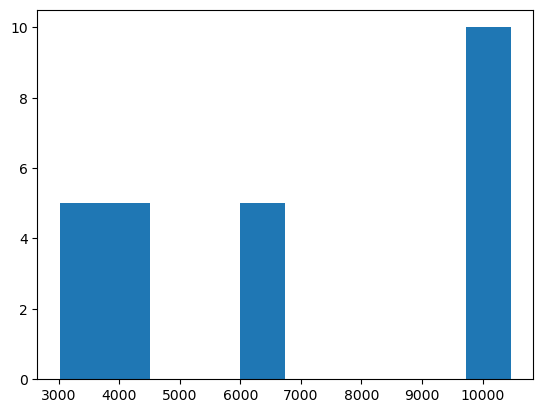

In [24]:
import matplotlib.pyplot as plt

ntokens = [len(sample.split()) for sample in dataset] # The number of tokens

plt.hist(ntokens)
plt.show()


### Examining the number of tokens

In [25]:
L, V, S = calculator.datasets[0][0]

print(f'L: {len(L)}, V: {len(V)}, S: {len(S)}')

L_lengths = [] 
for l in L: 
    length = len(poly_to_sequence(l).split())
    # print(length)
    L_lengths.append(length)

V_lengths = []
for v in V: 
    length = len(poly_to_sequence(v).split())
    # print(length)
    V_lengths.append(length)

S_lengths = []
for s in S: 
    length = len(poly_to_sequence(s).split())
    # print(length)
    S_lengths.append(length)

import numpy as np 
print(f'#tokens in L: {np.mean(L_lengths)}, {np.std(L_lengths)}, {np.min(L_lengths)}, {np.max(L_lengths)}')
print(f'#tokens in V: {np.mean(V_lengths)}, {np.std(V_lengths)}, {np.min(V_lengths)}, {np.max(V_lengths)}')
print(f'#tokens in S: {np.mean(S_lengths)}, {np.std(S_lengths)}, {np.min(S_lengths)}, {np.max(S_lengths)}')


L: 11, V: 8, S: 7
#tokens in L: 4.0, 0.0, 4, 4
#tokens in V: 145.875, 45.957691140874346, 64, 219
#tokens in S: 99.71428571428571, 34.5820526768863, 64, 159


In [12]:
L

[x1^3*x2^2,
 x0*x1^2*x2^2,
 x1^4*x2,
 x0*x1^3*x2,
 x0^2*x1^2*x2,
 x0^3*x1*x2,
 x0^4*x2,
 x1^5,
 x0*x1^4,
 x0^2*x1^3,
 x0^3*x1^2,
 x0^4*x1,
 x0^5,
 x2^6,
 x1*x2^5,
 x0*x2^5,
 x1^2*x2^4,
 x0*x1*x2^4,
 x0^2*x2^4,
 x0^2*x1*x2^3,
 x0^3*x2^3]

In [44]:
V

[x0*x1^4 - 13*x0^4*x2 + 10*x0^3*x1*x2 - 6*x0^2*x1*x2^2 - 6*x0^2*x2^3 + 3*x1^2*x2^3 - 14*x0^4 + 10*x0^3*x1 - 10*x0^2*x1^2 - 12*x0*x1^3 - x0^3*x2 + 15*x0^2*x1*x2 - 3*x0*x1^2*x2 - 11*x1^3*x2 + 4*x0^2*x2^2 + 14*x0*x1*x2^2 + 6*x1^2*x2^2 - 9*x0*x2^3 + 10*x1*x2^3 + 4*x2^4 - x0^3 + 10*x0^2*x1 + 6*x0*x1^2 - 15*x1^3 - 6*x0^2*x2 + 6*x0*x1*x2 + 10*x1^2*x2 - 7*x0*x2^2 + 15*x2^3 + x0^2 - 13*x0*x1 + 5*x1^2 - 4*x0*x2 - 12*x1*x2 + 4*x2^2 - 7*x0 - 5*x1 + 6*x2 + 4,
 x0^2*x1^3 + 2*x0^2*x1^2*x2 - 12*x0^2*x1*x2^2 + 5*x0*x1^2*x2^2 - 15*x1^3*x2^2 - 15*x0^3*x1 - 10*x0^2*x1^2 - 9*x0*x1^3 - 12*x1^4 + x0^2*x1*x2 - 10*x0*x1^2*x2 - 3*x1^3*x2 - 9*x0*x1*x2^2 - 8*x1^2*x2^2 + 5*x0*x2^3 + 2*x1*x2^3 + x0^2*x1 - 13*x0*x1^2 - 3*x1^3 - 11*x0^2*x2 - 7*x0*x1*x2 + 12*x1^2*x2 + 14*x0*x2^2 + 8*x1*x2^2 - x2^3 + 11*x0^2 - 13*x0*x1 - x1^2 - 7*x0*x2 + 4*x1*x2 - 4*x2^2 + 12*x0 - 3*x1 - 2*x2 - 6,
 x0^2*x1^2 + 12*x0*x1^3 + 2*x0^3*x2 + 5*x0*x1^2*x2 - 3*x0^2*x2^2 - 12*x1^2*x2^2 + 9*x0*x2^3 + 4*x0^3 + 6*x0^2*x1 + 12*x0*x1^2 - 15*x1^3 + 2*

In [45]:
BB

[x0^2 + 11*x0 - 12*x1 - 11*x2 + 13,
 x0*x1 + 9*x0 + 8*x1 + 6*x2 - 12,
 x1^2 + 5*x0 - 12*x1 + 8*x2 + 6,
 x0*x2 + 13*x0 + 14*x1 + 12*x2 + 7,
 x1*x2 + 8*x0 + 5*x1 + x2 - 13,
 x2^2 - 14*x0 - 14*x1 + 2*x2 + 5]

In [46]:
G

[x2^2 - 14*x0 - 14*x1 + 2*x2 + 5,
 x1*x2 + 8*x0 + 5*x1 + x2 - 13,
 x0*x2 + 13*x0 + 14*x1 + 12*x2 + 7,
 x1^2 + 5*x0 - 12*x1 + 8*x2 + 6,
 x0*x1 + 9*x0 + 8*x1 + 6*x2 - 12,
 x0^2 + 11*x0 - 12*x1 - 11*x2 + 13]

`BB`: The border basis in the original dataset

`G` : The computed border basis by improved border basis algorithm

- Two bases are different (probably because of some sorting). 
- But they generate the same ideals, so it's fine. 


In [47]:
ideal(G) == ideal(BB)
# ideal(G) == ideal(F)  # also good

True

In [48]:
O

[1, x2, x1, x0]

The order ideal and border basis contains terms upto degree 3. However, `L` and `V` contains very high degree terms -- is that reasonable? 

In [49]:
L

[x2^4,
 x1^2*x2^3,
 x0^2*x2^3,
 x1^3*x2^2,
 x0*x1^2*x2^2,
 x0^2*x1*x2^2,
 x0^2*x1^2*x2,
 x0^3*x1*x2,
 x0^4*x2,
 x0*x1^4,
 x0^2*x1^3,
 x0^4*x1]

In [52]:
from src.border_basis_lib.utils import is_order_ideal

is_order_ideal(L)

False

In [57]:
L, V, S = calculator.datasets[3][0]
L

[x0^3*x1^2,
 x0^2*x1^2*x2^2,
 x0^3*x1*x2^2,
 x0^4*x2^2,
 x1^5*x2,
 x0*x1^4*x2,
 x0^2*x1^3*x2,
 x0^5*x2,
 x1^6,
 x0*x1^5,
 x0^5*x1,
 x0^6,
 x0*x2^6,
 x1^2*x2^5,
 x0*x1*x2^5,
 x0^2*x2^5,
 x1^3*x2^4,
 x0*x1^2*x2^4,
 x0^2*x1*x2^4,
 x0^3*x2^4,
 x1^4*x2^3,
 x0*x1^3*x2^3]